In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib nbagg
import h5py

In [60]:
path = '../NionData/091021/'
name = 'GPrun_100iter_3_prediction_UCB_2_0.npy'
file_list = glob.glob(path + name)
print(file_list)
# print(filelist)

['../NionData/091021/GPrun_100iter_3_prediction_UCB_2_0.npy']


In [61]:
filename = file_list[0]
pred = np.load(filename)
abr = np.load(filename.replace('prediction','abr_coeff'))
ronch_array = np.load(filename.replace('prediction', 'ronchigram'))
best_seen = np.argmax(pred)

In [5]:
print(best_seen)
print(pred[best_seen])
print(ronch_array.shape)

92
[0.95282331]
(100, 128, 128)


<IPython.core.display.Javascript object>


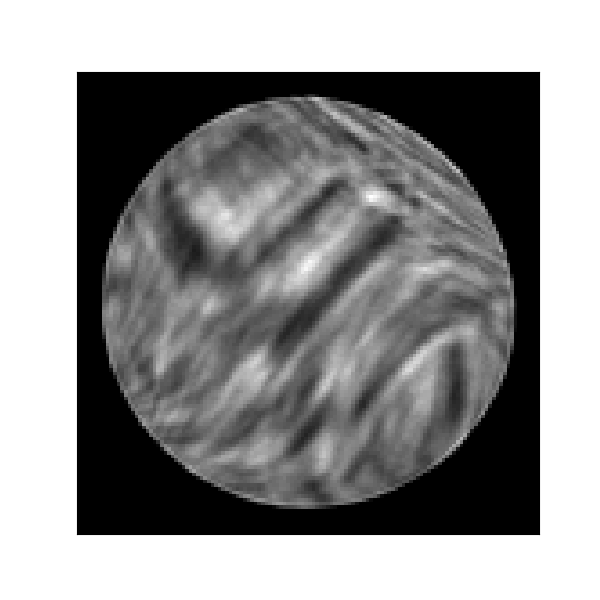

/home/chenyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/chenyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  after removing the cwd from sys.path.


[]

In [8]:
fig, ax = plt.subplots(1,1, figsize = [6, 6])
img = ax.imshow(ronch_array[92,:,:], extent = [-30,30,-30,30], cmap = 'gray')
ax.set_xticks([], [])
ax.set_yticks([], [])
# ax.set_xlabel(r'$\alpha_x$ (mrad)',fontsize = 16)
# ax.set_ylabel(r'$\alpha_y$ (mrad)', fontsize = 16)
# ax.tick_params(axis='x', labelsize=14)
# ax.tick_params(axis='y', labelsize=14)

In [9]:
abr_list = ["C10", "C12.x", "C12.y", "C21.x", "C21.y", "C23.x", "C23.y", "C30", 
"C32.x", "C32.y", "C34.x", "C34.y"]

abr_lim = [2e-7, 1.5e-7, 1.5e-7, 3e-6, 3e-6, 1e-5, 1e-5, 3e-4, 2e-4, 2e-4, 1.5e-4, 1.5e-4]

In [44]:
name = 'GPrun_150iter_0_prediction_UCB_2_0.npy'
abr_activate = [True, True, True, False, False, False, False, False, False, False, False, False]
abr_list_active = [abr_list[i] for i in np.arange(len(abr_list)) if abr_activate[i]]
print(abr_list_active)
file_list = glob.glob(path + name)
print(file_list)
filename = file_list[0]
pred = np.load(filename)
abr = np.load(filename.replace('prediction','abr_coeff'))
ronchigram = np.load(filename.replace('prediction', 'ronchigram'))
best_seen = np.argmax(pred)

['C10', 'C12.x', 'C12.y']
['../NionData/091021/GPrun_150iter_0_prediction_UCB_2_0.npy']


In [45]:
len(pred)

150

<IPython.core.display.Javascript object>


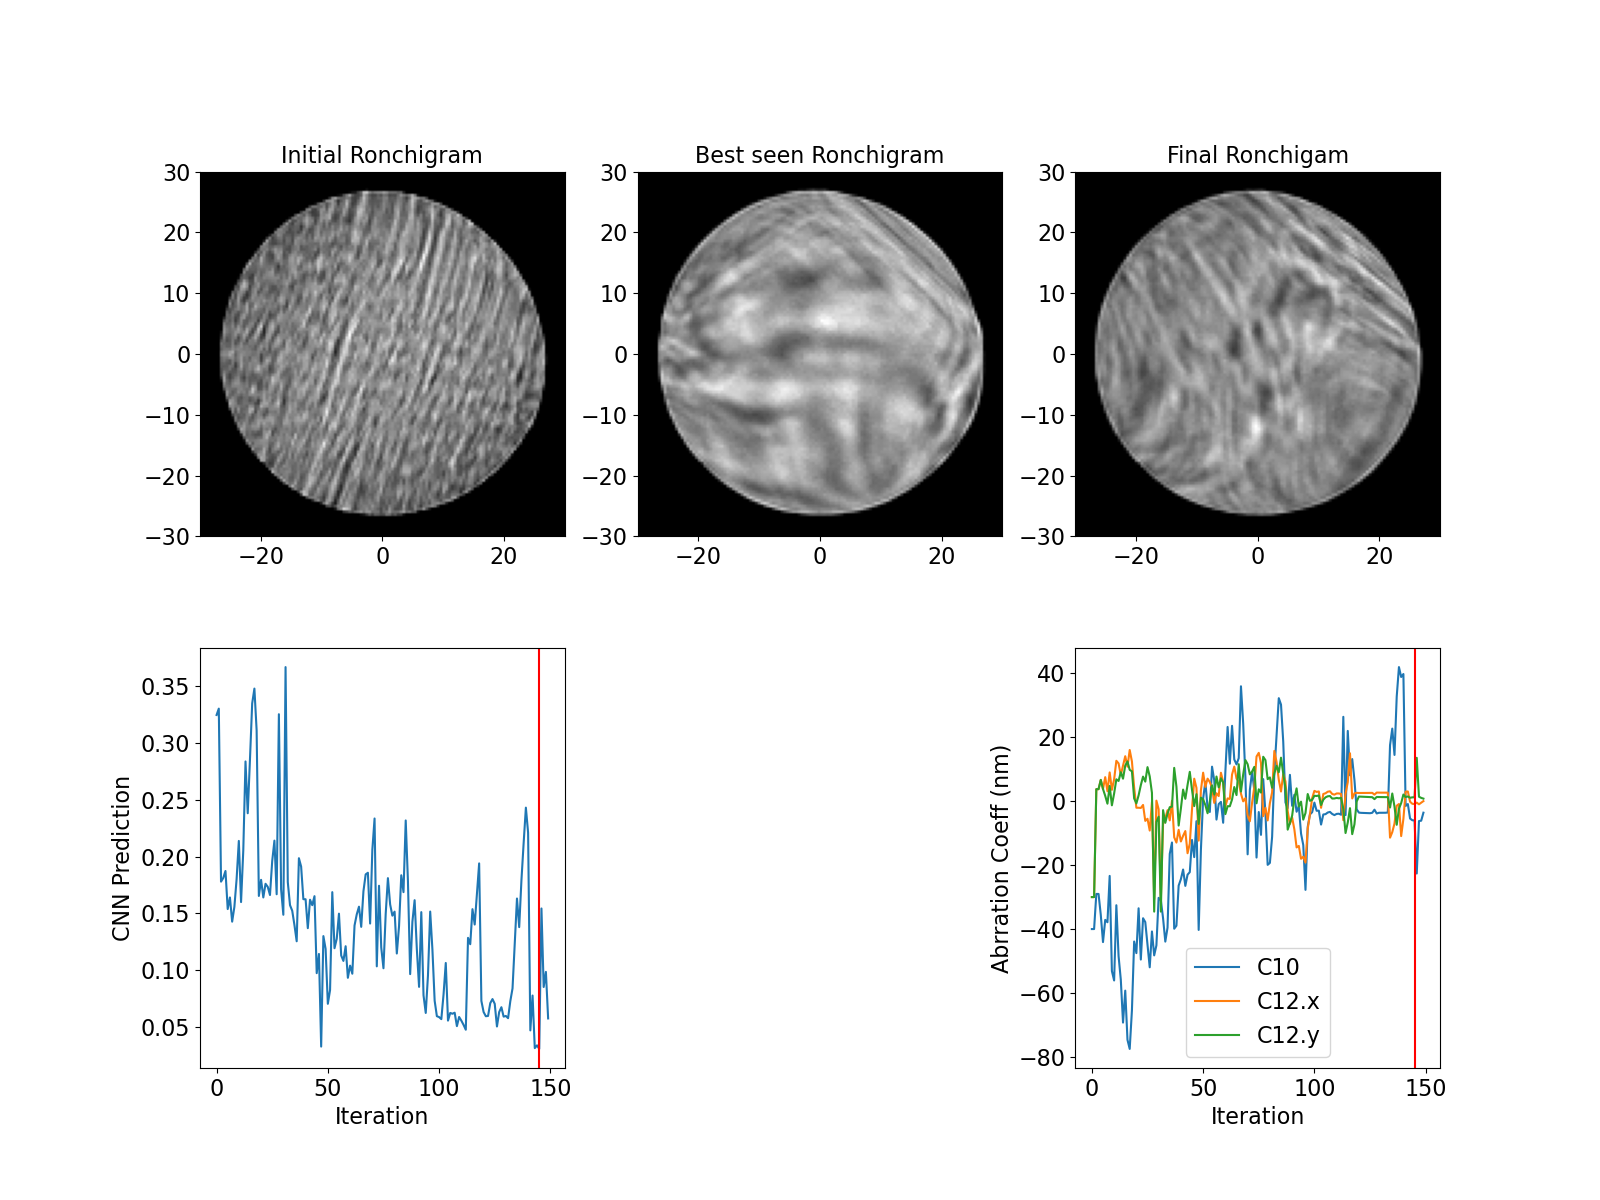

In [47]:
fig = plt.figure(constrained_layout = True, figsize = [16,12])
gs = plt.GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(ronchigram[0], extent = [-30,30,-30,30], cmap = 'gray')
ax1.tick_params(axis='both', labelsize=16)
ax1.set_title('Initial Ronchigram', fontsize = 16)

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(ronchigram[best_seen + 1], extent = [-30,30,-30,30], cmap = 'gray')
ax2.tick_params(axis='both', labelsize=16)
ax2.set_title('Best seen Ronchigram', fontsize = 16)

ax3 = fig.add_subplot(gs[0,2])
ax3.imshow(ronchigram[-1], extent = [-30,30,-30,30], cmap = 'gray')
ax3.tick_params(axis='both', labelsize=16)
ax3.set_title('Final Ronchigam', fontsize = 16)

# plot for normalized emittance
ax4 = fig.add_subplot(gs[1,0])
ax4.plot(1-pred)
ax4.set_xlabel('Iteration',fontsize = 16)
ax4.set_ylabel('CNN Prediction', fontsize = 16)
ax4.tick_params(axis='both', labelsize=16)
ax4.axvline(best_seen, c='r')

# aberration coefficients:
ax5 = fig.add_subplot(gs[1,2:3])
for i in range(abr.shape[1]):
    p = ax5.plot((abr[:,i] * abr_lim[i] - abr_lim[i] / 2) * 1e9, label = abr_list_active[i])
ax5.legend(fontsize = 16)
ax5.set_xlabel('Iteration',fontsize = 16)
ax5.set_ylabel('Abrration Coeff (nm)', fontsize = 16)
ax5.tick_params(axis='both', labelsize=16)
ax5.axvline(best_seen, c='r', label = 'best seen')

<IPython.core.display.Javascript object>


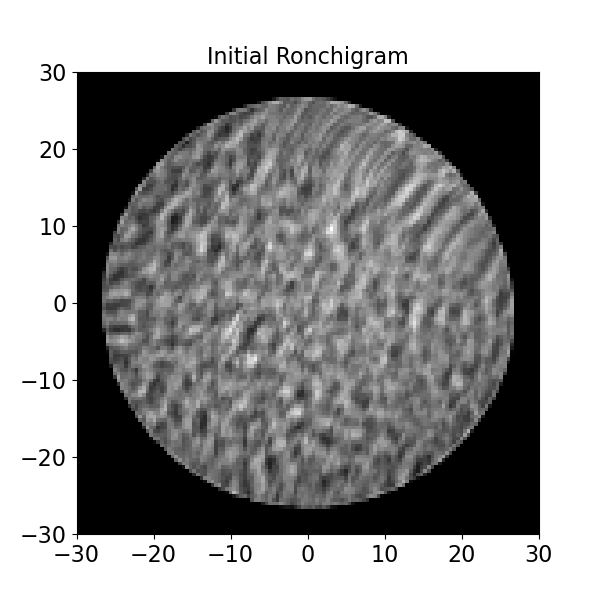

Text(0.5, 1.0, 'Initial Ronchigram')

In [20]:
fig = plt.figure(constrained_layout = True, figsize = [6,6])
gs = plt.GridSpec(1,1)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(ronchigram[-9], extent = [-30,30,-30,30], cmap = 'gray')
ax1.tick_params(axis='both', labelsize=16)
ax1.set_title('Initial Ronchigram', fontsize = 16)


## Recover the model evolution from the data recorded

In [236]:
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import importlib
import time
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/GPTrelated')
saveResultsQ = False
import scipy
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [174]:
# case with only 1 parameter
path = '../NionData/091021/'
name = 'GPrun_50iter_5_abr_coeff_UCB_2_0.npy'
x_list = np.load(path + name)
y_list = np.load(path + name.replace('abr_coeff', 'prediction'))
ronch_array = np.load(path + name.replace('abr_coeff', 'ronchigram'))
# print(filelist)

In [175]:
ndim = 1 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
start_point = [[0.9]]

mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, CNNoption = 0, DefocusOption = 0, S2 = 1) 
mi.aperture = 30

In [176]:
gp_ls = np.array(np.ones(ndim)) * [0.175] / 2
gp_amp = 0.143/2
gp_noise = 0.000053
gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))

ndim = len(dev_ids)
hyperparams = {'precisionMatrix': gp_precisionmat, 'amplitude_covar': gp_amp, 'noise_variance': gp_noise} 
gp = OGP(ndim, hyperparams)
gp.prmean = 0

#create the bayesian optimizer that will use the gp as the model to optimize the machine 
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
opt.ucb_params = np.array([2, None])
opt.iter_bound = True
opt.searchBoundScaleFactor = 2

Supposed to be grabbing initial machine state...


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Using GPT output.
x_init [[0.9]]
y_init [[-38.2443405]]


In [177]:
for i_iter in range(50):
    opt.model.update(np.array(x_list[i_iter], ndmin = 2), np.array(y_list[i_iter], ndmin = 2))

<IPython.core.display.Javascript object>


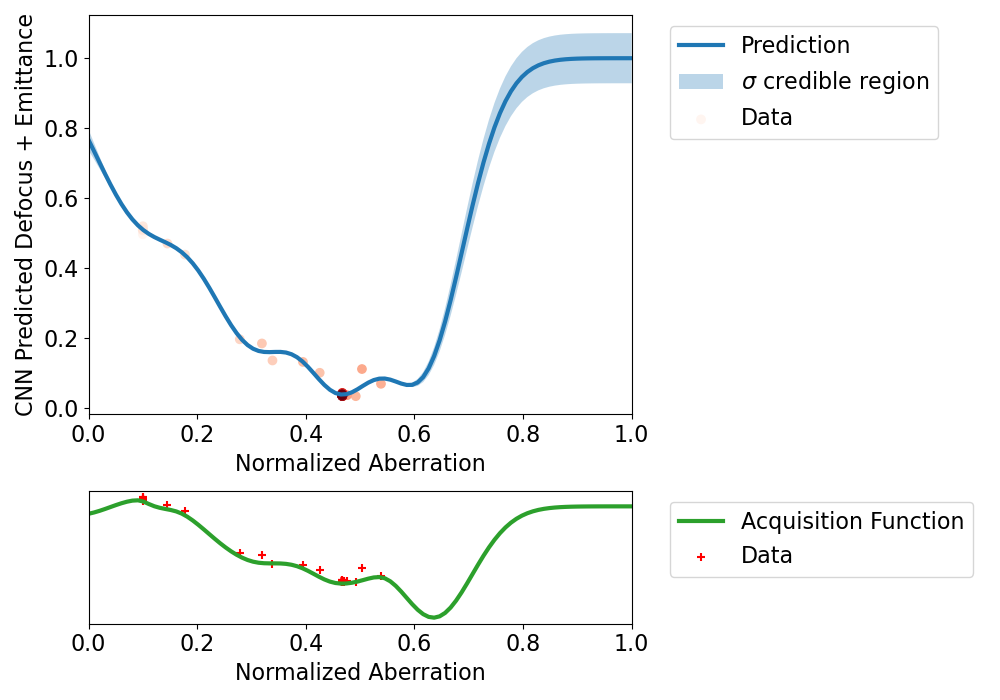

In [178]:

x = np.linspace(0,1,num = 100)
y = x*0
yval = x*0
yerr = x*0
for j in range(len(x)):
    y[j] = negUCB(x[j],opt.model, ndim, 1, opt.ucb_params[0], opt.ucb_params[1])
    yval[j] = opt.model.predict(np.array([x[j]],ndmin=2))[0][0]
    yerr[j] = opt.model.predict(np.array([x[j]],ndmin=2))[1][0]

clear_output(wait=True)
fig, (a0, a1) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[3,1]}, figsize = [10,7])

colors = cm.Reds(np.linspace(0, 1, len(x_list)))
p1 = a0.plot(x  ,1.0 - yval, linewidth = 3, label = 'Prediction')
a0.fill_between(x , 1.0 - yval - yerr, 1.0 - yval + yerr, alpha = 0.3, label = '$\sigma$ credible region')
p3 = a0.scatter(x_list, 1.0 - y_list, c=colors, label = 'Data')

a0.set_xlabel('Normalized Aberration',fontsize = 16)
a0.set_ylabel('CNN Predicted Defocus + Emittance', fontsize = 16)
a0.tick_params(axis='x', labelsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.legend(fontsize = 16, loc = 'upper left', bbox_to_anchor = [1.05, 1])
a0.set_xlim([0,1])

#     a1.scatter(x[np.argmin(y)] * 1800 + 1000, np.amin(y), s = 100, marker = "*",c='r')
a1.plot(x, y, linewidth = 3, label = 'Acquisition Function', c = 'C2')
a1.scatter(x_list, - y_list, marker = '+', c = 'r', label = 'Data')
a1.tick_params(axis='x', labelsize=16)
a1.set_xlabel('Normalized Aberration',fontsize = 16)
a1.set_yticks([])
a1.tick_params(axis='y', labelsize=16)
a1.legend(fontsize = 16, bbox_to_anchor = [1.05, 1])
a1.set_xlim([0,1])

plt.show()
fig.tight_layout()

<IPython.core.display.Javascript object>


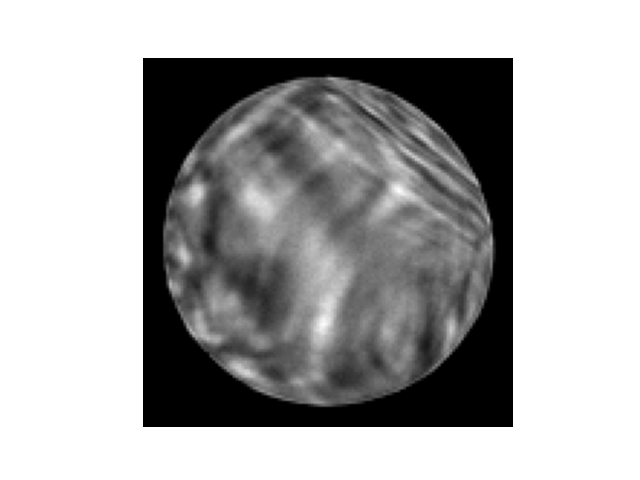

(-0.5, 127.5, 127.5, -0.5)

In [180]:
best_seen = np.argmax(y_list)
# print(best_seen)
# print(y_list)
plt.imshow(ronch_array[-1,:,:], cmap = 'gray')
plt.axis('off')

### Caes with two parameters

In [378]:
# case with only 1 parameter
path = '../NionData/091321/'
name = 'GPrun_2pars_100iter_0.h5'
f = h5py.File(path + name, 'r')
x_list = np.array(f['Data']['parameters'])
y_list = np.array(f['Data']['prediction'])

In [379]:
f['Data']['GP_parmeters']['prmean'].value

0

In [380]:
list(f['Data']['GP_parmeters'].keys())

['GP_amp',
 'GP_lengthscale',
 'GP_noise',
 'ndim',
 'niter',
 'prmean',
 'searchBoundScaleFactor',
 'start_point',
 'ucb_param']

In [381]:
ndim = 2 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
start_point = [[0.3, 0.3]]

mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, CNNoption = 0, DefocusOption = 0, S2 = 1) 
mi.aperture = 30

In [382]:
gp_ls = np.array(np.ones(ndim)) * [0.175, 0.075] / 2
gp_amp = 0.143/2
gp_noise = 0.000053
gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))

ndim = len(dev_ids)
hyperparams = {'precisionMatrix': gp_precisionmat, 'amplitude_covar': gp_amp, 'noise_variance': gp_noise} 
gp = OGP(ndim, hyperparams)
gp.prmean = 0

#create the bayesian optimizer that will use the gp as the model to optimize the machine 
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
opt.ucb_params = np.array([4, None])
opt.iter_bound = True
opt.searchBoundScaleFactor = 2

Supposed to be grabbing initial machine state...
Using GPT output.
x_init [[0.3 0.3]]
y_init [[-49.13133789]]


In [383]:
for i_iter in range(f['Data']['GP_parmeters']['niter'].value):
    opt.model.update(np.array(x_list[i_iter], ndmin = 2), np.array(y_list[i_iter], ndmin = 2))

In [384]:
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
UCB = np.zeros((100,100))

yval = UCB*0
for ix in range(len(x)):
    for iy in range(len(y)):
        UCB[ix,iy] = negUCB([x[ix],y[iy]],opt.model, ndim, 1, opt.ucb_params[0], opt.ucb_params[1])
        yval[ix,iy] = opt.model.predict(np.array([x[ix],y[iy]],ndmin=2))[0][0]

<IPython.core.display.Javascript object>


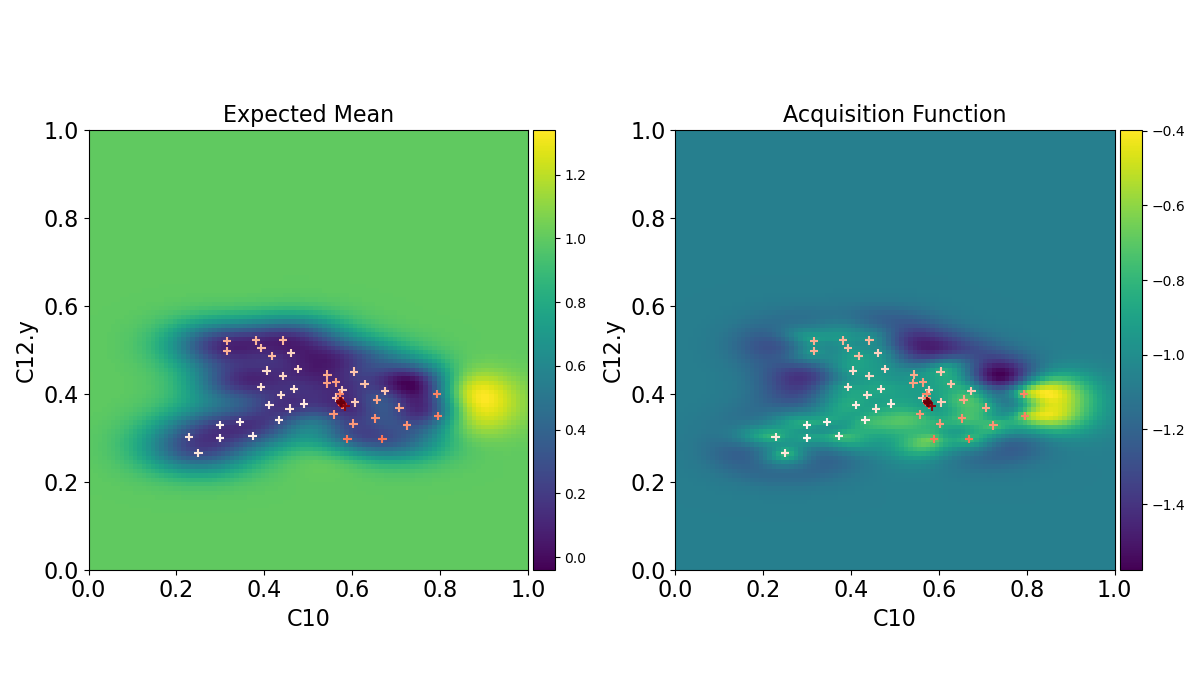

In [386]:
clear_output(wait=True)
fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1,1]}, figsize = [12,7])
colors = cm.Reds(np.linspace(0, 1, len(x_list)))

im0 = a0.imshow(np.transpose(1 - yval),origin='lower', extent = [0,1,0,1])
a0.tick_params(axis='x', labelsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.set_xlabel("C10", fontsize = 16)
a0.set_ylabel("C12.y", fontsize = 16)
a0.scatter(x_list[:,0], x_list[:,1], marker = '+', c = colors, label = 'Data')
a0.set_title('Expected Mean', fontsize = 16)

divider = make_axes_locatable(a0)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')

im1 = a1.imshow(np.transpose(UCB),origin='lower', extent = [0,1,0,1])
a1.tick_params(axis='x', labelsize=16)
a1.tick_params(axis='y', labelsize=16)
a1.set_xlabel("C10", fontsize = 16)
a1.set_ylabel("C12.y", fontsize = 16)
a1.scatter(x_list[:,0], x_list[:,1], marker = '+', c = colors, label = 'Data')
a1.set_title('Acquisition Function', fontsize = 16)

divider = make_axes_locatable(a1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

plt.show()
fig.tight_layout()

92


<IPython.core.display.Javascript object>


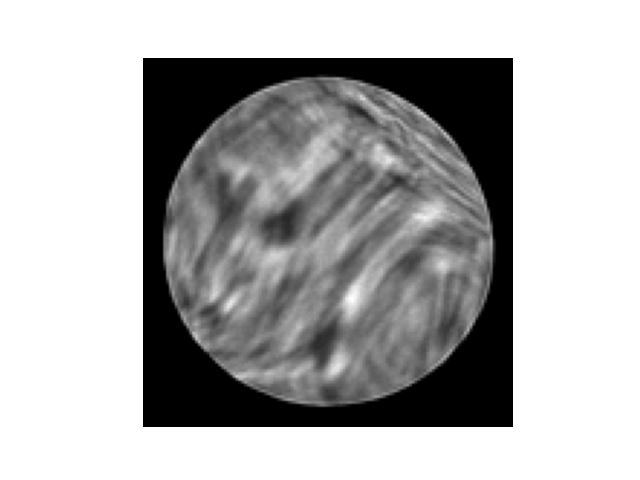

(-0.5, 127.5, 127.5, -0.5)

In [305]:
best_seen = np.argmax(y_list)
print(best_seen)
# print(y_list)
plt.imshow(ronch_array[99,:,:], cmap = 'gray')
plt.axis('off')